### Imports

In [1]:
import copy
import collections as coll
import functools as ft
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Main class

In [3]:
class Capture: # lazify?
    
    # Constructor
    def __init__(self, length, W, H, C, frames): # assume the parameters are correct
        self._length = length
        self._W = W
        self._H = H
        self._C = C
        self._frames = frames

    # Factories
    @classmethod
    def load(cls, path): # 'path' can be either a '.avi' or a wildcard for '.jpeg' images
        frames = []
        cap = cv2.VideoCapture(path)
        length, W, H, C = 0, 0, 0, 0
        ret, frame = cap.read()
        if ret:
            W, H, C = frame.shape
            frames.append((0, frame))
            length = 1
            ret, frame = cap.read()
            while ret:
                frames.append((length, frame))
                length = length + 1
                ret, frame = cap.read()
        cap.release()
        return cls(length, W, H, C, frames)

    @classmethod
    def concat(cls, captures):
        assert captures
        frames = captures[0]
        length, W, H, C = captures[0]._length, captures[0]._W, captures[0]._H, captures[0]._C
        max_index = captures[0]._frames[-1][0] if captures[0]._length else 0
        for capture in captures[1:]:
            assert capture._W == W and capture._H == H and capture._C == C
            frames.extend([(i+max_index, frame) for i, frame in capture._frames])
            length = length + capture._length
            max_index = max_index + capture._frames[-1][0] if capture._length else 0
        return cls(length, W, H, C, frames)

    # Misc
    def clone(self):
        return Capture(self._length, self._W, self._H, self._C, copy.deepcopy(self._frames))

    def write(self, path, fps=50):
        if self._length:
            assert self._C == 3
            out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc('M','J','P','G'), fps, (self._W, self._H))
            for _, frame in self._frames:
                out.write(frame)
            out.release()

    # Getters
    def length(self):
        return self._length

    def W(self):
        return self._W

    def H(self):
        return self._H

    def C(self):
        return self._C
    
    def frame(self, frame, index=True):
        if index:
            frames_dict = dict(self._frames)
            assert frame in frames_dict
            return frames_dict[frame]
        else:
            assert frame >= 0 and frame < self._length
            return self.frames[frame]

    def frames_dict(self):
        return dict(self._frames)

    # Index

    def index(self):
        return [i for i, _ in self._frames]
    
    def reset_index(self):
        self._frames = list(enumerate([frame for _, frame in self._frames]))

    # Iterators
    def frames(self, reverse=False):
        if not reverse:
            return iter(reversed(self._frames))
        else:
            return iter(self._frames)

    # Operations

    def filter(self, func):
        tmp = [(i, frame) for i, frame in self._frames if func(i, frame)]
        self._length = len(tmp)
        self._frames = tmp

    def extract(self, func):
        return [func(i, frame) for i, frame in self._frames]

    def foreach(self, func, zip=None, acc=None, reverse=False):
        for i in reversed(range(self._length)) if reverse else range(self._length):
            if acc is not None:
                if zip is not None:
                    if isinstance(zip, list):
                        assert len(zip) == self._length
                        acc = func(self._frames[i][0], self._frames[i][1], zip[i], acc)
                    elif isinstance(zip, dict):
                        assert set(zip.keys()).issubset(set(dict(self._frames).keys()))
                        acc = func(self._frames[i][0], self._frames[i][1], zip.get(self._frames[i][0], None), acc)
                else:
                    acc = func(self._frames[i][0], self._frames[i][1], acc)
            else:
                if zip is not None:
                    if isinstance(zip, list):
                        assert len(zip) == self._length
                        func(self._frames[i][0], self._frames[i][1], zip[i])
                    elif isinstance(zip, dict):
                        assert set(zip.keys()).issubset(set(dict(self._frames).keys()))
                        func(self._frames[i][0], self._frames[i][1], zip.get(self._frames[i][0], None))
                else:
                    func(self._frames[i][0], self._frames[i][1])

    def apply(self, func, zip=None, acc=None, reverse=False, shape=None):
        for i in reversed(range(self._length)) if reverse else range(self._length):
            if acc is not None:
                if zip is not None:
                    if isinstance(zip, list):
                        assert len(zip) == self._length
                        frame, acc = func(self._frames[i][0], self._frames[i][1], zip[i], acc)
                    elif isinstance(zip, dict):
                        assert set(zip.keys()).issubset(set(dict(self._frames).keys()))
                        frame, acc = func(self._frames[i][0], self._frames[i][1], zip.get(self._frames[i][0], None), acc)
                else:
                   frame, acc = func(self._frames[i][0], self._frames[i][1], acc)
            else:
                if zip is not None:
                    if isinstance(zip, list):
                        assert len(zip) == self._length
                        frame = func(self._frames[i][0], self._frames[i][1], zip[i])
                    elif isinstance(zip, dict):
                        assert set(zip.keys()).issubset(set(dict(self._frames).keys()))
                        frame = func(self._frames[i][0], self._frames[i][1], zip.get(self._frames[i][0], None))
                else:
                    frame = func(self._frames[i][0], self._frames[i][1])
            assert frame.shape == (shape if shape is not None else (self._W, self._H, self._C))
            self._frames[i] = (self._frames[i][0], frame)
        if shape is not None:
            self._W, self._H, self._C = shape


    def rolling(self, func, window, zip=None, acc=None, reverse=False, shape=None): # allow selecting position within window, allow lossless (fill ends with copies of end item), even window
        assert window % 2 == 1
        assert self._length >= window
        half_window = window // 2
        q, lq = (self._frames[-window:], self._length - window - 1) if reverse else (self._frames[:window], window)
        r = range(half_window, self._length - half_window)
        for i in reversed(r) if reverse else r:
            if acc is not None:
                if zip is not None:
                    if isinstance(zip, list):
                        assert len(zip) == self._length
                        frame, acc = func(self._frames[i][0], q, zip[i], acc)
                    elif isinstance(zip, dict):
                        assert set(zip.keys()).issubset(set(dict(self._frames).keys()))
                        frame, acc = func(self._frames[i][0], q, zip.get(self._frames[i][0], None), acc)
                else:
                   frame, acc = func(self._frames[i][0], q, acc)
            else:
                if zip is not None:
                    if isinstance(zip, list):
                        assert len(zip) == self._length
                        frame = func(self._frames[i][0], q, zip[i])
                    elif isinstance(zip, dict):
                        assert set(zip.keys()).issubset(set(dict(self._frames).keys()))
                        frame = func(self._frames[i][0], q, zip.get(self._frames[i][0], None))
                else:
                    frame = func(self._frames[i][0], q)
            assert frame.shape == (shape if shape is not None else (self._W, self._H, self._C))
            self._frames[i] = (self._frames[i][0], frame)
            if reverse:
                q.pop()
                q.insert(0, self._frames[lq])
                lq = lq - 1
            else:
                q.pop(0)
                q.append(self._frames[lq])
                lq = lq + 1
        if shape is not None:
            self._W, self._H, self._C = shape

    def __del__(self):
        self._frames = None


In [4]:
# get labels from .txt file
# input: path of the file
# output: dictionary where key = slice number, value = true (i, j) coordinates of the worm
# TODO: why do we keep the first slice value?
def load_labels(path):
    file = open(path, 'r')
    slice = -1
    ret = {}
    for i, line in enumerate(file.readlines()):
        fields = line.split()
        if i == 0 or fields[7] == slice:
            continue
        true_i = float(fields[6])
        true_j = float(fields[5])
        slice = int(fields[7])
        ret[slice] = (true_i, true_j)
    return ret

### Utils

In [5]:
def print_frame(single_channel=False):
    def _inner(i, frame, positions):
        W, H, C = frame.shape
        if single_channel:
            frame_p = np.zeros([W,H,3])
            frame_p[:,:,0] = frame/255
            frame_p[:,:,1] = frame/255
            frame_p[:,:,2] = frame/255
            frame = frame_p

        if positions:
            true_pos, estimated_pos = positions
            t1, t2 = true_pos[0], true_pos[1]
            e1, e2 = estimated_pos[0], estimated_pos[1]
            frame[t1-2:t1+2, t2-2:t2+2] = np.array([0, 1, 0])
            frame[e1-2:e1+2, e2-2:e2+2] = np.array([1, 0, 0])

        plt.imshow(frame, cmap='viridis')
        plt.show()
    return _inner

In [6]:
def select_channel(channel):
    def _inner(i, frame):
        frame = frame[:,:,channel:channel+1]
        return frame
    return _inner

### Preprocessing functions


In [7]:
# sets to 0 the borders of a one channel frame. 
# The width of the border is specified by n_pixels
def remove_borders(pixels):
    def _inner(i, frame):
        W, H, _ = frame.shape
        frame[:pixels, :, :] = frame[W-pixels:, :, :] = frame[:, :pixels, :] = frame[:, H-pixels:, :] = 0
    return _inner

In [8]:
def remove_outside_petri(center, radius_i, radius_j):
    def _inner(i, frame):
        W, H, _ = frame.shape
        I, J = np.ogrid[:W, :H]
        dist_from_center = ((I - center[0])/radius_i)**2 + ((J-center[1])/radius_j)**2
        mask = dist_from_center <= 1
        frame[~mask, :] = 0
    return _inner

### Metrics

In [8]:


"""
Calculates a custom accuracy, using ell infinity norm. 
For each frame, if estimated pos and labels are closer than distance small_radix,
we get a score of 1. Else if it's closer than big_radix, we get a score of 0.5. 
Otherwise, 0. Then, the accuracy is normalized between 0 and 1.
Input:
    labels: dict containing labels to the frames (some are missing)
    pos_hat: dict containing estimated pos to the frames
"""
def custom_accuracy(labels, pos_hat, small_radix=10, big_radix=10):
    def ell_inf_dist(p1, p2):
        return max(np.abs(p1[0] - p2[0]), np.abs(p1[1] - p2[1]))
    acc = 0
    for t in labels:
        if t in pos_hat:
            dist = ell_inf_dist(labels[t], pos_hat[t])
            if dist <= small_radix:
                acc += 1
            elif dist <= big_radix:
                acc += 0.5
    return acc / len(labels)

# Testing

In [59]:
o_cap = Capture.load('../data/pw1_A1_0315_part1.avi')

In [55]:
o_cap.H()

648

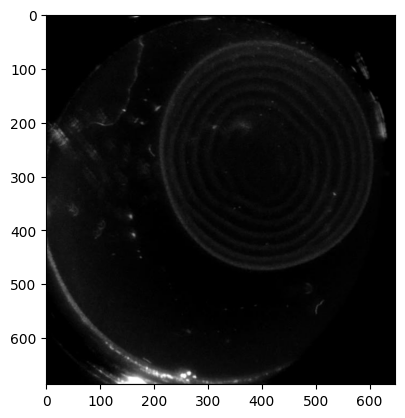

In [10]:
print_frame()(0, o_cap.frame(0), None)

In [60]:
cap = o_cap.clone()

In [61]:
cap.filter(lambda i, _: i > 5 and i < 20)

In [64]:
cap.reset_index()

In [66]:
cap.index()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [49]:
cap.extract(lambda _, x: np.sum(x))

[14110338,
 13976910,
 14267661,
 14210769,
 14014707,
 14232246,
 14247657,
 14095737,
 14049543,
 14057121,
 14088465,
 14221350,
 13970616,
 14115525]

In [30]:
cap.filter(lambda i, _: i > 5 and i < 20)
cap.apply(lambda i, x: x + np.ones(x.shape) * 200)

In [67]:
def __ii(i, x, z, a):
    print(dict(x).keys(), a)
    return x[len(x)//2+1][1], a+1
    

cap.rolling(__ii, 3, zip=list(range(14)), acc=1)

dict_keys([0, 1, 2]) 1
dict_keys([1, 2, 3]) 2
dict_keys([2, 3, 4]) 3
dict_keys([3, 4, 5]) 4
dict_keys([4, 5, 6]) 5
dict_keys([5, 6, 7]) 6
dict_keys([6, 7, 8]) 7
dict_keys([7, 8, 9]) 8
dict_keys([8, 9, 10]) 9
dict_keys([9, 10, 11]) 10
dict_keys([10, 11, 12]) 11
dict_keys([11, 12, 13]) 12


IndexError: list index out of range